# Applying Network Dissection to FCNs-PyTorch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# PyTorch libraies and modules
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# For handling Image data
import torchvision
import torchvision.transforms as transforms

## Loading and preprocessing data: CIFAR-10

In [2]:
# downloading data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainDataset = torchvision.datasets.CIFAR10(root='./dataset',
                                     train=True,
                                     transform=transform,
                                     download=False)

testDataset = torchvision.datasets.CIFAR10(root='./dataset',
                                     train=False, # test
                                     transform=transform,
                                     download=False)

In [3]:
# loading data
trainLoader = DataLoader(trainDataset, batch_size=8, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=8, shuffle=True)

In [4]:
# clear memory
del trainDataset, testDataset

## Defining FCNs

In [5]:
# Define the Network
class FCNs(nn.Module):    
    def __init__(self):
        super(FCNs, self).__init__()        
        self.layer1 = nn.Sequential(                        
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())            
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 30, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(30),
            nn.ReLU())        
        self.fc = nn.Sequential(
            nn.Linear(30*49, 128),            
            nn.Linear(128, 10))
        
    def forward(self, x):
        # print('input ', x.size())
        out = self.layer1(x)
        # print('layer1 ', out.size())
        out = self.layer2(out)
        # print('layer2 ', out.size())
        out = out.reshape(out.size(0), -1) # flatten
        # print('reshape ', out.size())
        out = self.fc(out)
        # print('fc ', out.size())        
        return out

In [6]:
# defining the model
model = FCNs()
# defining the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
# defining the loss function
lossFunction = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():    
    model = model.cuda()
    lossFunction = lossFunction.cuda()    
print(model)

FCNs(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1470, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [8]:
# defining the number of epochs
n_epochs = 100
# empty list to store training losses
losses = []
# Training
for epoch in range(n_epochs):
    for i, (inputs, labels) in enumerate(trainLoader):
        # getting variables        
        inputs, labels = Variable(inputs), Variable(labels)
        # using GPU
        if torch.cuda.is_available():       
            inputs, labels = inputs.cuda(), labels.cuda()       
        # Forward
        output = model(inputs)
        # computing loss
        loss = lossFunction(output, labels)
        # init. gradients of the model parameters
        optimizer.zero_grad()
        # computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()
    # stack loss (tensor -> value)
    losses.append(loss.item())
    print('Epoch : ', epoch+1, '\t', 'trn loss :', loss.item())

Epoch :  1 	 trn loss : 1.0649431943893433
Epoch :  2 	 trn loss : 1.4803555011749268
Epoch :  3 	 trn loss : 0.6625185012817383
Epoch :  4 	 trn loss : 0.6634326577186584
Epoch :  5 	 trn loss : 0.7228152751922607
Epoch :  6 	 trn loss : 0.7963672876358032
Epoch :  7 	 trn loss : 0.6826454401016235
Epoch :  8 	 trn loss : 1.2771373987197876
Epoch :  9 	 trn loss : 1.1242356300354004
Epoch :  10 	 trn loss : 1.0361604690551758
Epoch :  11 	 trn loss : 0.6516062021255493
Epoch :  12 	 trn loss : 0.487311452627182
Epoch :  13 	 trn loss : 1.3727649450302124
Epoch :  14 	 trn loss : 0.4070478081703186
Epoch :  15 	 trn loss : 0.9864946603775024
Epoch :  16 	 trn loss : 0.8645291328430176
Epoch :  17 	 trn loss : 0.5001485347747803
Epoch :  18 	 trn loss : 0.3659386932849884
Epoch :  19 	 trn loss : 0.5131548047065735
Epoch :  20 	 trn loss : 0.2083221971988678
Epoch :  21 	 trn loss : 0.9404758214950562
Epoch :  22 	 trn loss : 0.2606605887413025
Epoch :  23 	 trn loss : 0.384773254394531

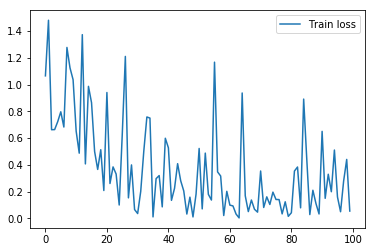

In [9]:
# plotting loss
plt.plot(losses, label='Train loss')
plt.legend()
plt.show()

## eval.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
device

device(type='cuda')

In [18]:
model.eval()
test_loss = 0
correct = 0
for images, labels in testLoader:
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs)    
    test_loss += lossFunction(output, labels).data[0]    
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(labels.data.view_as(pred)).sum()
    
test_loss /= len(testLoader.dataset)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


In [19]:
correct

tensor(1035, device='cuda:0')

In [20]:
print('average loss: %f'%test_loss.item())

average loss: 2.033127


In [21]:
print('Accuracy: {}/{} ({}%)'.format(correct.item(),len(testLoader.dataset),
                                    100. * correct / len(testLoader.dataset)))

Accuracy: 1035/10000 (10%)


### Save model

In [24]:
torch.save(model.state_dict(), './cnn.pth')

In [25]:
model = FCNs()
model.load_state_dict(torch.load('./cnn.pth'))

In [26]:
model.eval()

FCNs(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1470, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Applying Network Dissection